In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P3')

Mounted at /content/drive


**A talent sourcing and management company is interested in finding talented individuals for sourcing these candidates to technology companies. The nature of their job requires a lot of human labor and is full of manual operations.** 

**Towards automating this process the company wants us to build a better approach that could save them time and finally help them spot potential candidates that could fit the roles they are in search for. Moreover, going beyond that for a specific role they want to fill in they are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.** 

**First, they want to determine best matching candidates based on how fit these candidates are for a given role. They generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role they are trying to fill in. These keywords might change, and we can expect that specific keywords will be provided to us. After creating a list of the candidates and their fitness scores, the company is interested in being able to re-rank the candidates once a candidate is starred.** 



**Import libraries.**

In [ ]:
## data
import numpy as np
import pandas as pd

## visualisations
import seaborn as sns
import matplotlib.pyplot as plt

## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")


!pip install --upgrade --pre gensim

import gensim
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
import gensim.models

!pip install glove-python-binary
from glove import Corpus, Glove


import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.corpus import stopwords

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
from itertools import combinations

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

In [ ]:
## Load data
data = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [ ]:
data.shape

(104, 5)

In [ ]:
len(data['id'].unique())

104

- **The 'fit' column contains only NaNs so let's drop it.**

In [ ]:
data.drop('fit',axis=1,inplace=True)

In [ ]:
## check for duplicates
duplicates_check = data.copy()
duplicates_check.drop(columns=['id'],axis=1,inplace=True)
print(f'There are {duplicates_check.duplicated().sum()} duplicates.')

There are 51 duplicates.


- **There are 51 duplicates. We will drop them since we don't need them.**

In [ ]:
data = data.set_index('id')
## drop duplicates
data.drop_duplicates(inplace=True)
print(f'There are {data.shape[0]} distinct entries.')

There are 53 distinct entries.


In [ ]:
data.head()

,job_title,location,connection
id,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
2,Native English Teacher at EPIK (English Progra...,Kanada,500+
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
4,People Development Coordinator at Ryan,"Denton, Texas",500+
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


**Let's take a closer look at the main column of interest: 'job_title'**

In [ ]:
data['job_title'].value_counts()

Aspiring Human Resources Professional                                                                                    2
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 1
Lead Official at Western Illinois University                                                                             1
Senior Human Resources Business Partner at Heil Environmental                                                            1
Aspiring Human Resources Professional | An energetic and Team-Focused Leader                                             1
HR Manager at Endemol Shine North America                                                                                1
Human Resources professional for the world leader in GIS software                                                        1
RRP Brand Portfolio Executive at JTI (Japan Tobacco International)                                                       1
Information Syst

- **The text in each entry of 'job_title' contains numbers, special characters, whitespace, both capital and small letters, acronyms, and stopwords.**

- **Let's define a function that deals with these problems to clean the text.**

In [ ]:
def clean_text(text):

  ## tokenize
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(text)

  ## lemmatize + lowercase
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token.lower(), pos='v') for token in tokens]
  
  ## remove stopwords
  keep_words = [token for token in tokens if token not in stopwords.words('english')]
  row_text = ' '.join(keep_words)
  row_text = ' '.join([word for word in row_text.split() if len(word)>1])  ## remove one letter words
  row_text = re.sub(r'\w*\d\w*', '', row_text).strip()
  return row_text

In [ ]:
data['job_title'] = data['job_title'].apply(clean_text)

- **We manually replace acronyms.**

In [ ]:
data.replace({'job_title' : {'magna cum laude' : 'with great distinction', 'chro' : 'chief human resources officer', 'svp' : 'senior vice president'
        ,'gphr' : 'global professional in human resources', 'hris' : 'human resources information system'
        , 'csr' : 'corporate social responsibility', 'sphr' : 'strategic and policy-making certification'
        , 'hr' : 'human resources', 'rrp' : 'recommended retail prices'}}, regex=True, inplace=True)

In [ ]:
data['job_title'] = data['job_title'].apply(clean_text)

In [ ]:
data.head()

,job_title,location,connection
id,,,
1,bauer college business graduate great distinct...,"Houston, Texas",85
2,native english teacher epik english program korea,Kanada,500+
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44
4,people development coordinator ryan,"Denton, Texas",500+
5,advisory board member celal bayar university,"İzmir, Türkiye",500+


- **We manually fix some problems in the 'location' column.**

In [ ]:
data.replace({'location' : {'Amerika Birleşik Devletleri' : 'United States of America', 'Houston, Texas Area' : 'Houston, Texas', 'Austin, Texas Area' : 'Austin, Texas',
                            'Kanada' : 'Canada', 'Kokomo, Indiana Area' : 'Kokomo, Indiana', 'Türkiye' : 'Turkey'}}, regex=True, inplace=True)

In [ ]:
data.head()

,job_title,location,connection
id,,,
1,bauer college business graduate great distinct...,"Houston, Texas",85
2,native english teacher epik english program korea,Canada,500+
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44
4,people development coordinator ryan,"Denton, Texas",500+
5,advisory board member celal bayar university,"İzmir, Turkey",500+


**Now, we need to find a way to convert text into numbers to represent them mathematically.**

Word embedding techniques are used to represent words mathematically.

TF-IDF vectorization involves calculating the TF-IDF score for every word in your corpus relative to that document and then putting that information into a vector. Thus each document in your corpus would have its own vector, and the vector would have a TF-IDF score for every single word in the entire collection of documents. Once you have these vectors you can apply them to various use cases such as seeing if two documents are similar by comparing their TF-IDF vector using cosine similarity.

Ref: https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/

- The higher the TF-IDF score the more important or relevant the term is; as a term gets less relevant, its TF-IDF score will approach 0.
- TF is the frequency of any 'term' in a given 'document'.
- IDF is constant per corpus, and accounts for the ratio of documents that include that specific 'term'.

Symbolisation:
- t : term (word)
- d : document (set of words)
- D : corpus (the total document set)
- n : # of d in D 

--------------------------------------------------------------------------
- $tf(t,d)$ = count$(t : t \in d)$ / count(words $\in$ d)
 
 or
 
 $tf(t,d) = \mathrm{log}\bigl(count(t : t \in d) + 1 \bigr)$ 
--------------------------------------------------------------------------- 

- $idf(t,D) = \mathrm{log}\bigl(\frac{n}{count(d \in D: t \in d)}\bigr)$

 or from Skicit-learn

 $idf(t,D) = \mathrm{log}\bigl(\frac{n+1}{count(d \in D: t \in d)+1}\bigr)+1$ 

-------------------------------------------------------------------------

- $tfidf(t,d,D) = tf(t,d) \cdot idf(t,D)$, where $\cdot$ represents the dot product.

**A common way to measure similarity is using the cosine function as below:**

$\text{cosine similarity}=S_{C}(A,B):=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}= \frac {\sum \limits _{i=1}^{n}A_{i}B_{i} } {\sqrt {\sum \limits _{i=1}^{n}A_{i}^{2} } \sqrt {\sum \limits _{i=1}^{n}B_{i}^{2} } }$

In [ ]:
def tf_idf(feature, keyword,df):

    ## put df's rows in a list. This is our corpus.
    corpus = df[feature].tolist()

    ## append the keywords at the end of the corpus so we can compare it with the rest of the rows.
    corpus.append(clean_text(keyword))    
    
    ## create a matrix of tf-idf features.
    tfvec = TfidfVectorizer()    
    tf_idf_all = tfvec.fit_transform(corpus) ## vectorisation
    #tf_idf_all_df = pd.DataFrame(tf_idf_all.toarray(), columns = tfvec.get_feature_names())

    ## similarity of each row of the initial corpus with the keywords using cosine similarity.
    cos_sim = cosine_similarity(tf_idf_all.toarray()[:-1], tf_idf_all.toarray()[-1].reshape(1, -1))

    ## append the sorted similarities on a new column of our dataframe.
    df['cosine_similarity'] = cos_sim
    df = df.sort_values('cosine_similarity', ascending=False)
    return df

In [ ]:
data_aspiring = data.copy()
data_aspiring = tf_idf('job_title','Aspiring human resources', data_aspiring)
data_aspiring.head(n=15)

,job_title,location,connection,cosine_similarity
id,,,,
97,aspire human resources professional,"Kokomo, Indiana",71,0.757836
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836
6,aspire human resources specialist,Greater New York City Area,1,0.665663
73,aspire human resources manager seek internship...,"Houston, Texas",7,0.601381
27,aspire human resources management student seek...,"Houston, Texas",500+,0.424475
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.422144
66,experience retail manager aspire human resourc...,"Austin, Texas",57,0.403974
74,human resources professional,Greater Boston Area,16,0.393191
7,student humber college aspire human resources ...,Canada,61,0.382504


In [ ]:
data_seeking = data.copy()
data_seeking = tf_idf('job_title','seeking human resources', data_seeking)
data_seeking.head(n=10)

,job_title,location,connection,cosine_similarity
id,,,,
99,seek human resources position,"Las Vegas, Nevada Area",48,0.685990
28,seek human resources opportunities,"Chicago, Illinois",390,0.662609
73,aspire human resources manager seek internship...,"Houston, Texas",7,0.616508
10,seek human resources human resources informati...,Greater Philadelphia Area,500+,0.508548
27,aspire human resources management student seek...,"Houston, Texas",500+,0.449193
74,human resources professional,Greater Boston Area,16,0.372009
94,seek human resources opportunities open travel...,United States of America,415,0.359944
100,aspire human resources manager graduate may se...,"Cape Girardeau, Missouri",103,0.353925
75,nortia staff seek human resources payroll admi...,"San Jose, California",500+,0.320370


**TF-IDF vectorization seems to perform quite well, but there is some room for improvement. So let's try some more word embedding techniques.**

**Word2Vector**

In [ ]:
def word2vector(feature, keyword, df, min_count=1, window=5, epochs=10):

    ## put df's rows in a list. This is our corpus.
    corpus = df[feature].tolist()

    #kw = clean_text(keyword)
    
    tokens = [word_tokenize(row) for row in corpus]

    model = Word2Vec(tokens, min_count=min_count, window=window,sg=1,batch_words=10)
    model.train(tokens, total_examples=1, epochs=epochs)

    p = np.array(0.)
    for k in keyword:
      p = p + model.wv[k]
    
    cs = []
    
    for i in tokens:
      a = np.array(0.)
      for j in i:
        if j in keyword:
          a = a + model.wv[j]
      cs.append(cosine_similarity(np.mean(np.array(p)).reshape(-1, 1), np.mean(a).reshape(-1, 1)).item())
    
    #cs_series = pd.Series(cs)
    df['cosine_similarity'] = np.array(cs)
    df = df.sort_values('cosine_similarity', ascending=False)
    return df

In [ ]:
d_w2v = data.copy()
d_w2v = word2vector('job_title', ['aspire', 'human', 'resources'], d_w2v)
d_w2v

,job_title,location,connection,cosine_similarity
id,,,,
1,bauer college business graduate great distinct...,"Houston, Texas",85,1.0
83,human resources manager endemol shine north am...,"Los Angeles, California",268,1.0
74,human resources professional,Greater Boston Area,16,1.0
75,nortia staff seek human resources payroll admi...,"San Jose, California",500+,1.0
76,aspire human resources professional passionate...,"New York, New York",212,1.0
77,human resources conflict management policies p...,Dallas/Fort Worth Area,409,1.0
79,liberal arts major aspire human resources analyst,"Baton Rouge, Louisiana Area",7,1.0
81,senior human resources business partner heil e...,"Chattanooga, Tennessee Area",455,1.0
82,aspire human resources professional energetic ...,"Austin, Texas",174,1.0


**The Word2Vector technique gave a score of 1 or 0 allowing us to filter out candidates that should not be on the list in the first place.**

**FastText**

In [ ]:
def fast_text(feature, keyword, df):

    ## put df's rows in a list. This is our corpus.
    corpus = df[feature].tolist()

    tokens = [word_tokenize(row) for row in corpus]

    model = FastText(tokens,sg=1,batch_words=10,hs=1)
   
    cs = []
    for i in tokens:
      cs.append(model.wv.n_similarity(i, keyword))

    df['similarity'] = np.array(cs)
    df = df.sort_values('similarity', ascending=False)
    return df

In [ ]:
d_fasttext = data.copy()
d_fasttext = fast_text('job_title', ['aspire', 'human', 'resources'], d_fasttext)
d_fasttext

,job_title,location,connection,similarity
id,,,,
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.938710
97,aspire human resources professional,"Kokomo, Indiana",71,0.938710
6,aspire human resources specialist,Greater New York City Area,1,0.925639
73,aspire human resources manager seek internship...,"Houston, Texas",7,0.842671
74,human resources professional,Greater Boston Area,16,0.748705
66,experience retail manager aspire human resourc...,"Austin, Texas",57,0.739754
27,aspire human resources management student seek...,"Houston, Texas",500+,0.720906
7,student humber college aspire human resources ...,Canada,61,0.695602
68,human resources specialist luxottica,Greater New York City Area,500+,0.667074


**GloVe**

In [ ]:
def glove_(feature, keyword, df):

    # creating a corpus object
    corpus = Corpus() 
    tokens = [word_tokenize(row) for row in df[feature].tolist()]
    #training the corpus to generate the co occurence matrix which is used in GloVe
    corpus.fit(tokens, window=10)
    #creating a Glove object which will use the matrix created in the above lines to create embeddings
    #We can set the learning rate as it uses Gradient Descent and number of components
    glove = Glove(no_components=10, learning_rate=0.05)
    
    glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
    glove.add_dictionary(corpus.dictionary)


    p = np.array(0.)
    for k in keyword:
      p = p + glove.word_vectors[glove.dictionary[k]]
    
    cs = []
    
    for i in tokens:
      a = np.array(0.)
      for j in i:
        if j in keyword:
          a = a + glove.word_vectors[glove.dictionary[j]]
      cs.append(cosine_similarity(np.mean(np.array(p)).reshape(-1, 1), np.mean(a).reshape(-1, 1)).item())
    
    #cs_series = pd.Series(cs)
    df['cosine_similarity'] = np.array(cs)
    df = df.sort_values('cosine_similarity', ascending=False)
    return df

In [ ]:
d_glove = data.copy()
d_glove = glove_('job_title', ['aspire', 'human', 'resources'], d_glove)
d_glove

- **FastText's results are a bit better than TF-IDF's but there are still some candidates that should be ranked differently. e.g. candidate with id 100 should have been higher on the list.**

- **GloVe just like word2vector allows us to filter out the candidates that should not have been on the list in the first place.**

**Let's now try use a Sentence Transformer, as they are the current state-of-the-art in NLP.**

In [ ]:
def sentence_transformer(feature, keyword,df):
  
  model = SentenceTransformer('all-MiniLM-L6-v2')
  ## put df's rows in a list. This is our corpus.
  corpus = df[feature].tolist()  

  ## encode each row of our df
  emb_corpus = model.encode(corpus)

  ## encode the cleaned keyword
  emb_kw = model.encode(clean_text(keyword))

  #Compute cosine-similarities
  cosine_scores = util.cos_sim(emb_corpus, emb_kw).numpy()

  ## append the sorted similarities on a new column of our dataframe.
  df['cosine_similarity'] = cosine_scores
  df = df.sort_values('cosine_similarity', ascending=False)
  return df

In [ ]:
d_sentence_transformer = data.copy()
d_sentence_transformer = sentence_transformer('job_title', 'Aspiring human resources', d_sentence_transformer)
d_sentence_transformer

,job_title,location,connection,cosine_similarity
id,,,,
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.928787
97,aspire human resources professional,"Kokomo, Indiana",71,0.928787
6,aspire human resources specialist,Greater New York City Area,1,0.916763
74,human resources professional,Greater Boston Area,16,0.718712
66,experience retail manager aspire human resourc...,"Austin, Texas",57,0.708162
73,aspire human resources manager seek internship...,"Houston, Texas",7,0.707531
100,aspire human resources manager graduate may se...,"Cape Girardeau, Missouri",103,0.696831
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.695717
79,liberal arts major aspire human resources analyst,"Baton Rouge, Louisiana Area",7,0.695704


**The results seem to be slightly better now but still not perfect.**

**Next we want to rerank the candidates when a candidate is starred.**

In [ ]:
df_starred = d_sentence_transformer.copy()
df_starred['starred_fit'] = df_starred['cosine_similarity']
df_starred.head()

,job_title,location,connection,cosine_similarity,starred_fit
id,,,,,
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.928787,0.928787
97,aspire human resources professional,"Kokomo, Indiana",71,0.928787,0.928787
6,aspire human resources specialist,Greater New York City Area,1,0.916763,0.916763
74,human resources professional,Greater Boston Area,16,0.718712,0.718712
66,experience retail manager aspire human resourc...,"Austin, Texas",57,0.708162,0.708162


In [ ]:
def starred():
  '''
    This function asks for the id of the candidates who starred.
    
  '''
  star_ids = []
  for id in input('Enter the ids of the candidates who starred: ').split():
    if int(id) in df_starred.index:
      star_ids.append(int(id))
    else:
      print(f'id {id} is not valid. Please, choose a valid id:')
      starred()
  return star_ids

In [ ]:
star_ids = starred()
df_starred['starred_fit'][star_ids] = 1

In [ ]:

df_starred.head()

,job_title,location,connection,cosine_similarity,starred_fit
id,,,,,
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.928787,1.000000
97,aspire human resources professional,"Kokomo, Indiana",71,0.928787,0.928787
6,aspire human resources specialist,Greater New York City Area,1,0.916763,0.916763
74,human resources professional,Greater Boston Area,16,0.718712,0.718712
66,experience retail manager aspire human resourc...,"Austin, Texas",57,0.708162,0.708162


Ref: https://lucidworks.com/post/abcs-learning-to-rank/#:~:text=What%20Is%20Learning%20To%20Rank,it's%20what%20orders%20query%20results.

- Learning to rank (LTR) is a class of algorithmic techniques that apply supervised machine learning to solve ranking problems in search relevancy. 

- The three major approaches to LTR are known as pointwise, **pairwise**, and listwise.

- **RankNet**, LambdaRank, and LambdaMART are popular learning to rank algorithms developed by researchers at Microsoft Research. All make use of pairwise ranking.

- **Pairwise** approaches look at two documents together. They also use classification or regression — to decide which of the pair ranks higher.

- We compare this higher-lower pair against the ground truth and adjust the ranking if it doesn’t match. The goal is to minimize the number of cases where the pair of results are in the wrong order relative to the ground truth (also called inversions).

- RankNet is a pairwise approach and uses the GD to update the model parameters in order to minimize the cost (RankNet was presented with the Cross-Entropy cost function). This is like defining the force and the direction to apply when updating the positions of the two candidates (the one ranked higher up in the list while the other one down but with the same force).

Ref: https://medium.com/swlh/ranknet-factorised-ranknet-lambdarank-explained-implementation-via-tensorflow-2-0-part-i-1e71d8923132

RankNet

Model Target
Instead of modelling the score of each document one by one, RankNet proposed to model the target probabilities between any two documents ($d_{i}$ & $d_{j}$) of the same query.

And the target probabilities $P_{ij}$ of $d_{i}$ and $d_{j}$ is defined as:
  - 1 if $s_{i} > s_{j}$
  - 0.5 if $s_{i} = s_{j}$
  - 0 if $s_{i} < s_{j}$

where $s_{i}$ and $s_{j}$ are the scores of $d_{i}$ and $d_{j}$ respectively.

Model Architecture

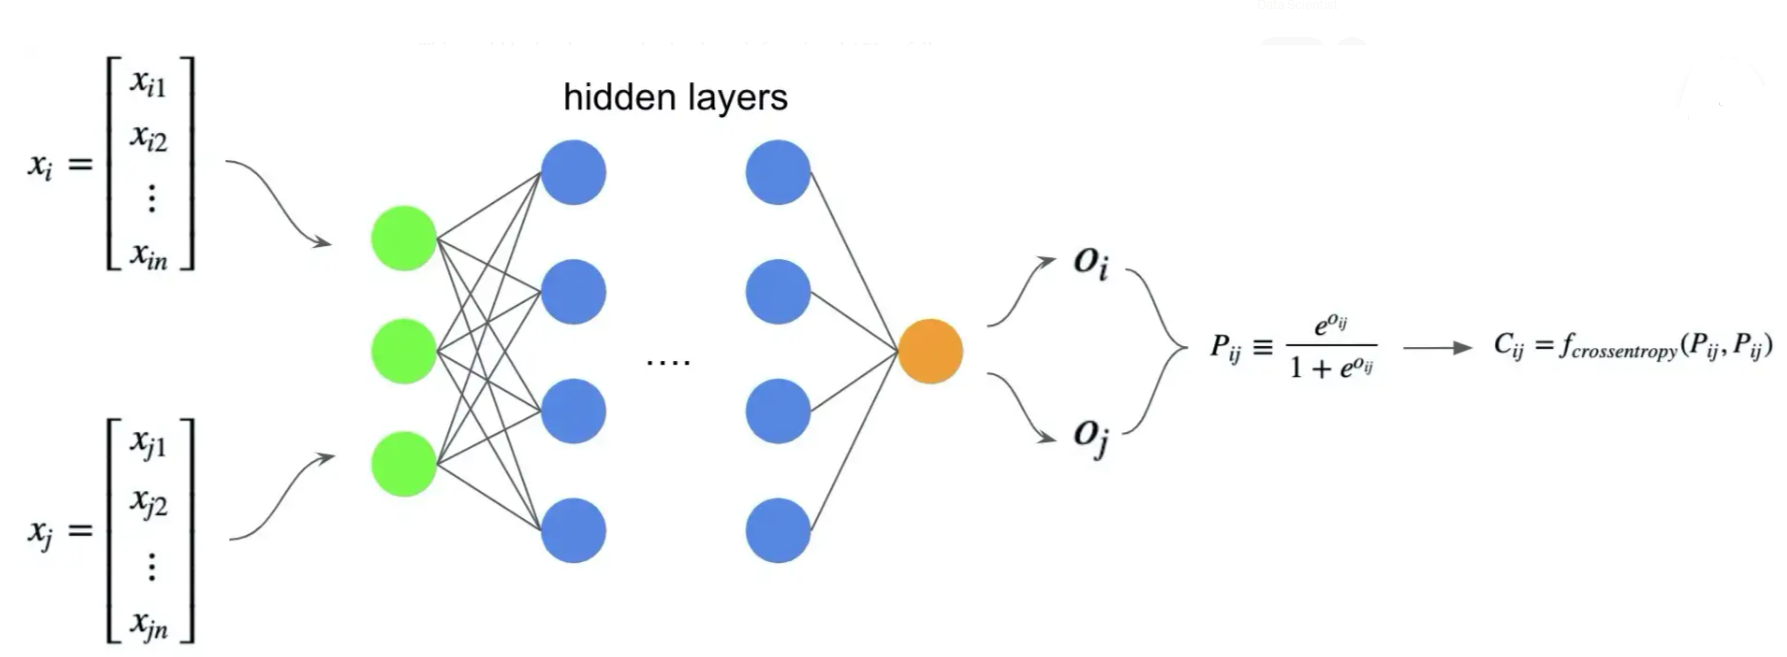

In [ ]:
## RankNet model
class RankNet(nn.Module):
    def __init__(self, input, output): ## model.encode(job_title) has shape (384,)
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input, 256),            ## linear layer
            #nn.Dropout(0.25),                 ##  dropout 
            nn.LeakyReLU(0.2, inplace=True), ## activation = leakyrelu

            nn.Linear(256, 128),
            #nn.Dropout(0.25),
            nn.LeakyReLU(0.2, inplace=True), 

            nn.Linear(128, output)
            # nn.Linear(128, 64), 
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(64, 32), 
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(32, 16), 
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(16, 8), 
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Linear(8, output)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in1, in2):          ##  input 2 documents
        out1 = self.model(in1)            ##  output of first doc
        out2 = self.model(in2)            ##  output of 2nd doc
        out = self.sigmoid(out1 - out2)   ##  apply sigmoid to get final probability
        return out

    def predict(self, x):
        return self.sigmoid(self.model(x))

In [ ]:
## sentence transformer 
model_bert = SentenceTransformer('all-MiniLM-L6-v2')

## input shape
shape = model_bert.encode(df_starred['job_title'][3]).size

## ranking model
model_rank = RankNet(input=shape,output=1)

## binary crossentropy loss function - multi-label classification
criterion = nn.BCELoss() 
#criterion = nn.CrossEntropyLoss()

- First, we need to create the target labels for each pair of candidates.

In [ ]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

print(f'There are {nCr(df_starred.shape[0],2)} pairs of candidates.')

There are 1378 pairs of candidates.


In [ ]:
## score pairs
l = list(combinations(df_starred['starred_fit'],2))

## split the scores into 2 lists
l1 = []
l2 = []
for i in range(len(l)):
  l1.append(l[i][0])
  l2.append(l[i][1])

## labels 
y = torch.tensor([1.0 if y1 > y2 else 0.5 if y1 == y2 else 0.0 for y1, y2 in zip(l1,l2)]).float()
y_ = y.unsqueeze(1)

- Next we need to encode all entries and create pairs of the candidates.

In [ ]:
## encode all rows using the model from sentence transformer
sentence_emb = []


for i in df_starred['job_title']:
  sentence_emb.append(model_bert.encode(i))

## split the encoded combinations into 2 lists
sentence_emb_comb = list(combinations(sentence_emb,2))
sentence_emb_l1 = []
sentence_emb_l2 = []

for i in range(len(sentence_emb_comb)):
  sentence_emb_l1.append(sentence_emb_comb[i][0])
  sentence_emb_l2.append(sentence_emb_comb[i][1])

In [ ]:
def train(model, criterion, optim, learning_rates, num_epochs):
  
  for lr in learning_rates:
    if optim == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
    elif optim == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    print('Optimizer: ', optim, 'Learning_rate: ', lr)
    print('--------------------------------------------')

    for epoch in range(num_epochs):
      
      o = []
      for i,j in zip(sentence_emb_l1, sentence_emb_l2):
        i = torch.from_numpy(i).float().clone().detach().requires_grad_(True)
        j = torch.from_numpy(j).float().clone().detach().requires_grad_(True)
        o.append(model(i, j))
       
      loss = criterion(torch.tensor(o).view(-1,1), y_.clone().detach().requires_grad_(True))

      ## back propagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % 50 == 0:
        print("Epoch: [{}/{}]\t| Loss : {:.4f}".format(epoch+1, num_epochs, loss.item()))
   
    print()

  return model, loss 

In [ ]:
model_SGD, loss_SGD = train(model_rank, criterion, 'SGD', [0.1], num_epochs=200)
model_Adam, loss_Adam = train(model_rank, criterion, 'Adam', [0.1], num_epochs=200)

Optimizer:  SGD Learning_rate:  0.1
--------------------------------------------
Epoch: [1/200]	| Loss : 0.6932
Epoch: [51/200]	| Loss : 0.6932
Epoch: [101/200]	| Loss : 0.6932
Epoch: [151/200]	| Loss : 0.6932

Optimizer:  Adam Learning_rate:  0.1
--------------------------------------------
Epoch: [1/200]	| Loss : 0.6932
Epoch: [51/200]	| Loss : 0.6932
Epoch: [101/200]	| Loss : 0.6932
Epoch: [151/200]	| Loss : 0.6932



In [ ]:
df_rerank = d_sentence_transformer.copy()
df_rerank['starred_fit'] = df_rerank['cosine_similarity']
df_rerank.head()
star_ids = starred()
df_rerank['starred_fit'][star_ids] = 1

Enter the ids of the candidates who starred: 1 2 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#final_model = 

In [ ]:
pred_scores = []
for i in df_rerank['job_title']:
    
    sentence_emb = torch.from_numpy(model_bert.encode(i)).float().clone().detach().requires_grad_(True)
    
    model_pred = round(model_SGD.predict(sentence_emb).detach().numpy().sum(),2)
    pred_scores.append(model_pred)

df_rerank['rerank_fit'] = pred_scores
df_rerank.sort_values(by ='rerank_fit', ascending = False)

,job_title,location,connection,cosine_similarity,starred_fit,rerank_fit
id,,,,,,
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.928787,1.000000,0.51
80,junior mes engineer information systems,"Myrtle Beach, South Carolina Area",52,0.284012,0.284012,0.51
101,human resources generalist loparex,"Raleigh-Durham, North Carolina Area",500+,0.569098,0.569098,0.51
81,senior human resources business partner heil e...,"Chattanooga, Tennessee Area",455,0.528106,0.528106,0.51
84,human resources professional world leader gi s...,"Highland, California",50,0.501938,0.501938,0.51
12,senior vice president chief human resources of...,"Houston, Texas",500+,0.492106,0.492106,0.51
70,retire army national guard recruiter office ma...,"Virginia Beach, Virginia",82,0.480588,0.480588,0.51
4,people development coordinator ryan,"Denton, Texas",500+,0.450898,0.450898,0.51
77,human resources conflict management policies p...,Dallas/Fort Worth Area,409,0.442761,0.442761,0.51
